In [62]:
import pickle
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [63]:
import pandas as pd
df = pd.read_csv('ddi_w_smiles.csv')
dfa = df[['drug_a', 'drug_a_can_smiles']]
dfb = df[['drug_b', 'drug_b_can_smiles']]
dfb.columns = ['drug_a', 'drug_a_can_smiles']
dff = pd.concat([dfa, dfb], axis=0)
dff.reset_index(drop=True, inplace=True)
dff

drug_a  \
0                       Naltrexone   
1                         Abacavir   
2               Aluminum hydroxide   
3                       Aprepitant   
4                  Calcium acetate   
...                            ...   
177859                  Iodipamide   
177860                   Iodixanol   
177861  Physostigmine (ophthalmic)   
177862                 Edrophonium   
177863  Physostigmine (ophthalmic)   

                                        drug_a_can_smiles  
0       O=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...  
1           Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1  
2                                [Al+3].[OH-].[OH-].[OH-]  
3       C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...  
4                            CC(=O)[O-].CC(=O)[O-].[Ca+2]  
...                                                   ...  
177859  O=C(CCCCC(=O)Nc1c(I)cc(I)c(C(=O)O)c1I)Nc1c(I)c...  
177860  CC(=O)N(CC(O)CN(C(C)=O)c1c(I)c(C(=O)NCC(O)CO)c...  
177861        CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C  
177862                            CC[N+](C)(C)c1cccc(O)c1  
177863        CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C  

[177864 rows x 2 columns]

In [64]:
dff = dff.drop_duplicates()
dff.reset_index(drop=True, inplace=True)
dff

drug_a  \
0                   Naltrexone   
1                     Abacavir   
2           Aluminum hydroxide   
3                   Aprepitant   
4              Calcium acetate   
...                        ...   
1436                 Tivozanib   
1437  Homatropine (ophthalmic)   
1438               Benzonatate   
1439           Tyropanoic acid   
1440                    Oxygen   

                                      drug_a_can_smiles  
0     O=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...  
1         Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1  
2                              [Al+3].[OH-].[OH-].[OH-]  
3     C[C@@H](O[C@H]1OCCN(Cc2n[nH]c(=O)[nH]2)[C@H]1c...  
4                          CC(=O)[O-].CC(=O)[O-].[Ca+2]  
...                                                 ...  
1436  COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c...  
1437     CN1[C@H]2CC[C@@H]1C[C@H](OC(=O)C(O)c1ccccc1)C2  
1438  CCCCNc1ccc(C(=O)OCCOCCOCCOCCOCCOCCOCCOCCOCCOC)cc1  
1439             CCCC(=O)Nc1c(I)cc(I)c(CC(CC)C(=O)O)c1I  
1440                                                O=O  

[1441 rows x 2 columns]

In [71]:
drug_dict = dff.set_index('drug_a')['drug_a_can_smiles'].to_dict()
filename = 'drug_dict.sav'
pickle.dump(drug_dict, open(filename, 'wb'))

In [66]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit import DataStructs
import rdkit
import numpy as np

user_input1 = 'Dolutegravir'
user_input2 = 'Ondansetron'

input1_smiles = drug_dict[user_input1]
input2_smiles = drug_dict[user_input2]

ddi_dict = {'name': [user_input1, user_input2], 'smiles': [input1_smiles, input2_smiles]}

ddi_df = pd.DataFrame.from_dict(ddi_dict)
ddi_df

PandasTools.AddMoleculeColumnToFrame(ddi_df,'smiles','struc',includeFingerprints=True)

name                                             smiles  \
0  Dolutegravir  C[C@@H]1CCO[C@H]2Cn3cc(C(=O)NCc4ccc(F)cc4F)c(=...   
1   Ondansetron                  Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O   

                                               struc  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   

                                           drug_a_fp  
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
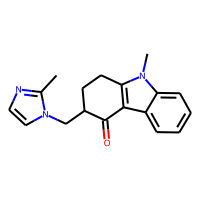

In [67]:
fplist = []
for mol in ddi_df['struc']:
    fp = Chem.GetMorganFingerprintAsBitVect( mol,2 )
    fp_arr = np.zeros((0,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    fplist.append(fp_arr)
ddi_df['drug_a_fp']=fplist
ddi_df

In [68]:
# rules for combining two fingerprints into 1
input1_fp_arr = ddi_df.at[0, 'drug_a_fp']
input2_fp_arr = ddi_df.at[1, 'drug_a_fp']

combined_fp_arr = np.empty(2048, dtype=int)

for j in range(2048):
    if (input1_fp_arr[j] == 0 & input2_fp_arr[j] == 0) | (input1_fp_arr[j] == 1 & input2_fp_arr[j] == 1):
        combined_fp_arr[j] = 1
    else:
        combined_fp_arr[j] = 0
combined_fp_arr.size

2048

In [69]:
loaded_model.predict(combined_fp_arr.reshape(1,-1))

array([1])

Naltrexone
Abacavir
Aluminum hydroxide
Aprepitant
Calcium acetate
Calcium carbonate
Dolutegravir
Cimetidine
Clarithromycin
Clotrimazole
Dexamethasone
Lamivudine
Magnesium sulfate
Metformin
Miconazole
Troglitazone
Zidovudine
Betamethasone
Alosetron
Budesonide
Bupropion
Dexlansoprazole
Dolasetron
Dronabinol
Eliglustat
Esomeprazole
Glyburide
Hydrocortisone
Lansoprazole
Linagliptin
Naldemedine
Naloxegol
Nateglinide
Nitisinone
Omeprazole
Ondansetron
Pantoprazole
Pioglitazone
Prednisolone
Prednisone
Rabeprazole
Repaglinide
Rolapitant
Saxagliptin
Sibutramine
Simvastatin
Tinidazole
Triamcinolone
Abiraterone
Dexfenfluramine
Famotidine
Fenfluramine
Lactulose
Levofloxacin
Loperamide
Metoclopramide
Metronidazole
Palonosetron
Papaverine
Phenolphthalein
Rosiglitazone
Ascorbic acid
Paclitaxel
Rosuvastatin
Isotretinoin
Doxycycline
Tetracycline
Vitamin A
Fentanyl
Atropine
Dicyclomine
Hyoscyamine
Mazindol
Morphine
Morphine (liposomal)
Nabilone
Phentermine
Propantheline
Scopolamine
Trospium
Acetylsalicyl